In [61]:
#import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We will load data, processed data and plot some first vizualisation to explore data

Import the character and add the header:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

and have a first look at the database

In [62]:
character_header = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age at movie release', 'Freebase actor map ID', 'Freebase character ID', 'Freebase actor ID']
pd_character = pd.read_table('data/character.metadata.tsv', names=character_header)

pd_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Wikipedia movie ID          450669 non-null  int64  
 1   Freebase movie ID           450669 non-null  object 
 2   Movie release date          440674 non-null  object 
 3   Character name              192794 non-null  object 
 4   Actor date of birth         344524 non-null  object 
 5   Actor gender                405060 non-null  object 
 6   Actor height                154824 non-null  float64
 7   Actor ethnicity             106058 non-null  object 
 8   Actor name                  449441 non-null  object 
 9   Actor age at movie release  292556 non-null  float64
 10  Freebase actor map ID       450669 non-null  object 
 11  Freebase character ID       192804 non-null  object 
 12  Freebase actor ID           449854 non-null  object 
dtypes: float64(2),

In [63]:
display(pd_character)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


Import the Movie Metadata and add the header::

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

and have a first look at the database

In [64]:
movie_header = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
pd_movie = pd.read_table('data/movie.metadata.tsv', names=movie_header)
pd_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wikipedia movie ID        81741 non-null  int64  
 1   Freebase movie ID         81741 non-null  object 
 2   Movie name                81741 non-null  object 
 3   Movie release date        74839 non-null  object 
 4   Movie box office revenue  8401 non-null   float64
 5   Movie runtime             61291 non-null  float64
 6   Movie languages           81741 non-null  object 
 7   Movie countries           81741 non-null  object 
 8   Movie genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [65]:
display(pd_movie)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


We need to preprocess the data to check if there is problem on the data and fix it !

We begin to check for movie

In [66]:
#check for NaN values for each columns
print('Check for NaN values:')
print(pd_movie.isna().sum())


Check for NaN values:
Wikipedia movie ID              0
Freebase movie ID               0
Movie name                      0
Movie release date           6902
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie countries                 0
Movie genres                    0
dtype: int64


In [67]:
#The movie release date need to be converted to datetime format
pd_movie['Movie release date'] = pd.to_datetime(pd_movie['Movie release date'], errors='coerce')
print(pd_movie.isna().sum())

Wikipedia movie ID              0
Freebase movie ID               0
Movie name                      0
Movie release date          42369
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie countries                 0
Movie genres                    0
dtype: int64


A lot of date were not converted to datetime format !

In [68]:
#Check for duplicate entries
print('Check for duplicate entries:')
print(pd_movie.duplicated().sum())

#Check for duplicate entries with name only
print('Check for duplicate entries with name only:')
print(pd_movie.duplicated(subset=['Movie name']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with name and date release:')
print(pd_movie.duplicated(subset=['Movie name', 'Movie release date']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with name and movie runtime:')
print(pd_movie.duplicated(subset=['Movie name', 'Movie runtime']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with wikipedia ID:')
print(pd_movie.duplicated(subset=['Wikipedia movie ID']).sum())

Check for duplicate entries:
0
Check for duplicate entries with name only:
6263
Check for duplicate entries with name and date release:
1708
Check for duplicate entries with name and movie runtime:
628
Check for duplicate entries with wikipedia ID:
0


We have some duplicate entries for the name film but the wikipedia ID is unique

<Axes: title={'center': 'Distribution of movie release date'}, xlabel='Movie release date', ylabel='Count'>

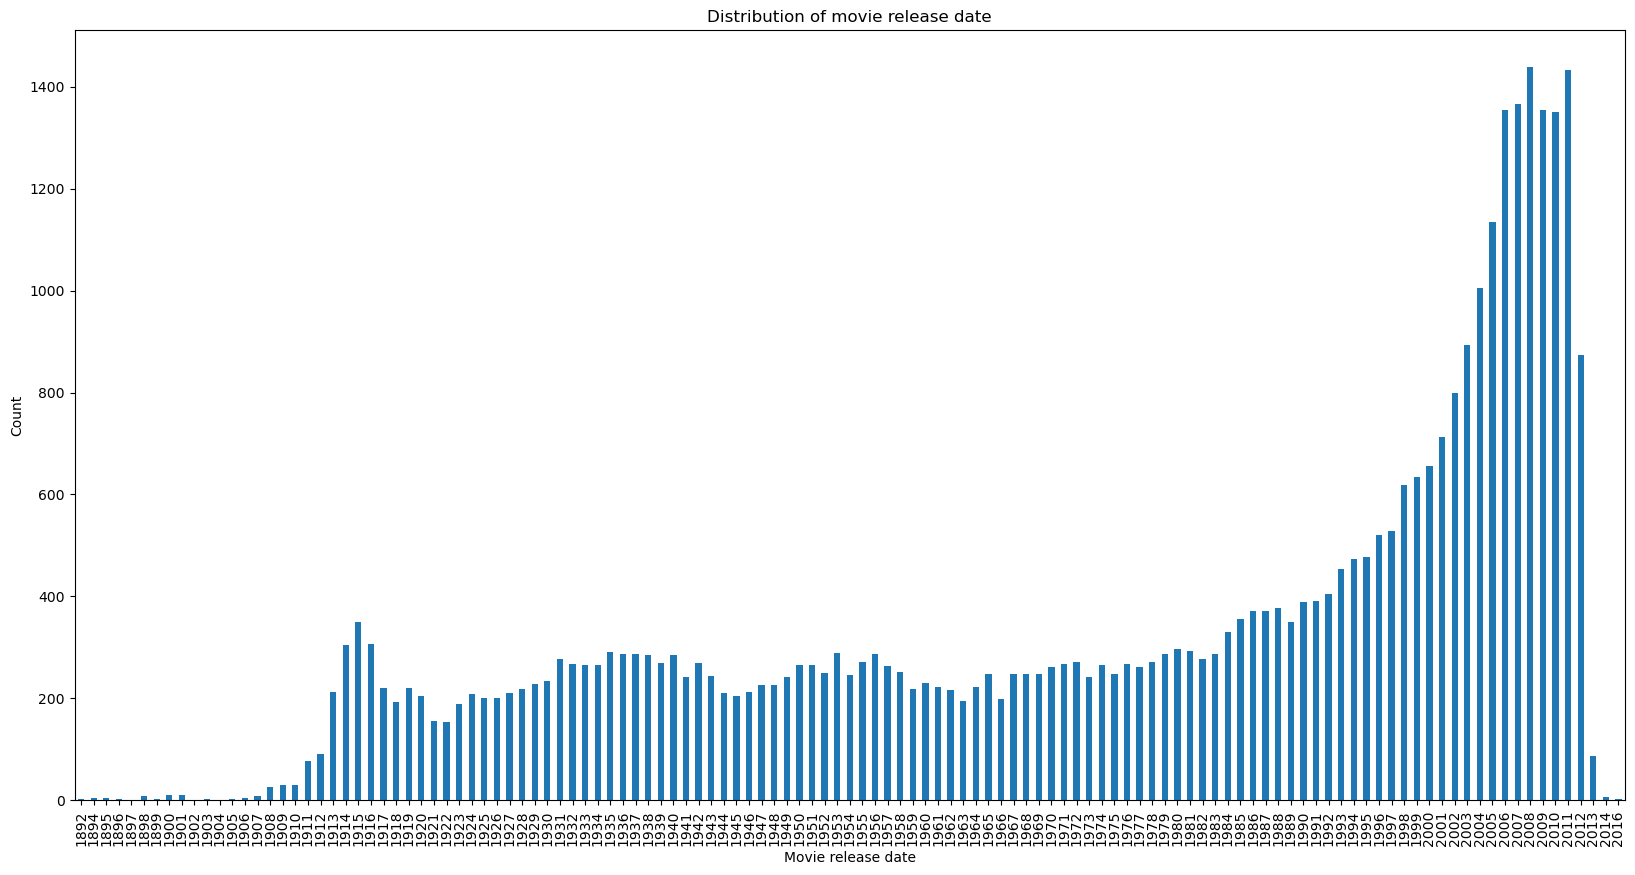

In [69]:
#Show the distribution of movie release date of 100 bins
plt.figure(figsize=(20,10))
plt.title('Distribution of movie release date')
plt.xlabel('Movie release date')
plt.ylabel('Count')
pd_movie.dropna(subset=['Movie release date'])['Movie release date'].dt.year.sort_values().value_counts(sort=False).plot(kind='bar')

The data in 2014 and 2016 seems false

<Axes: title={'center': 'Log distribution of movie runtime'}, xlabel='Movie runtime', ylabel='Count'>

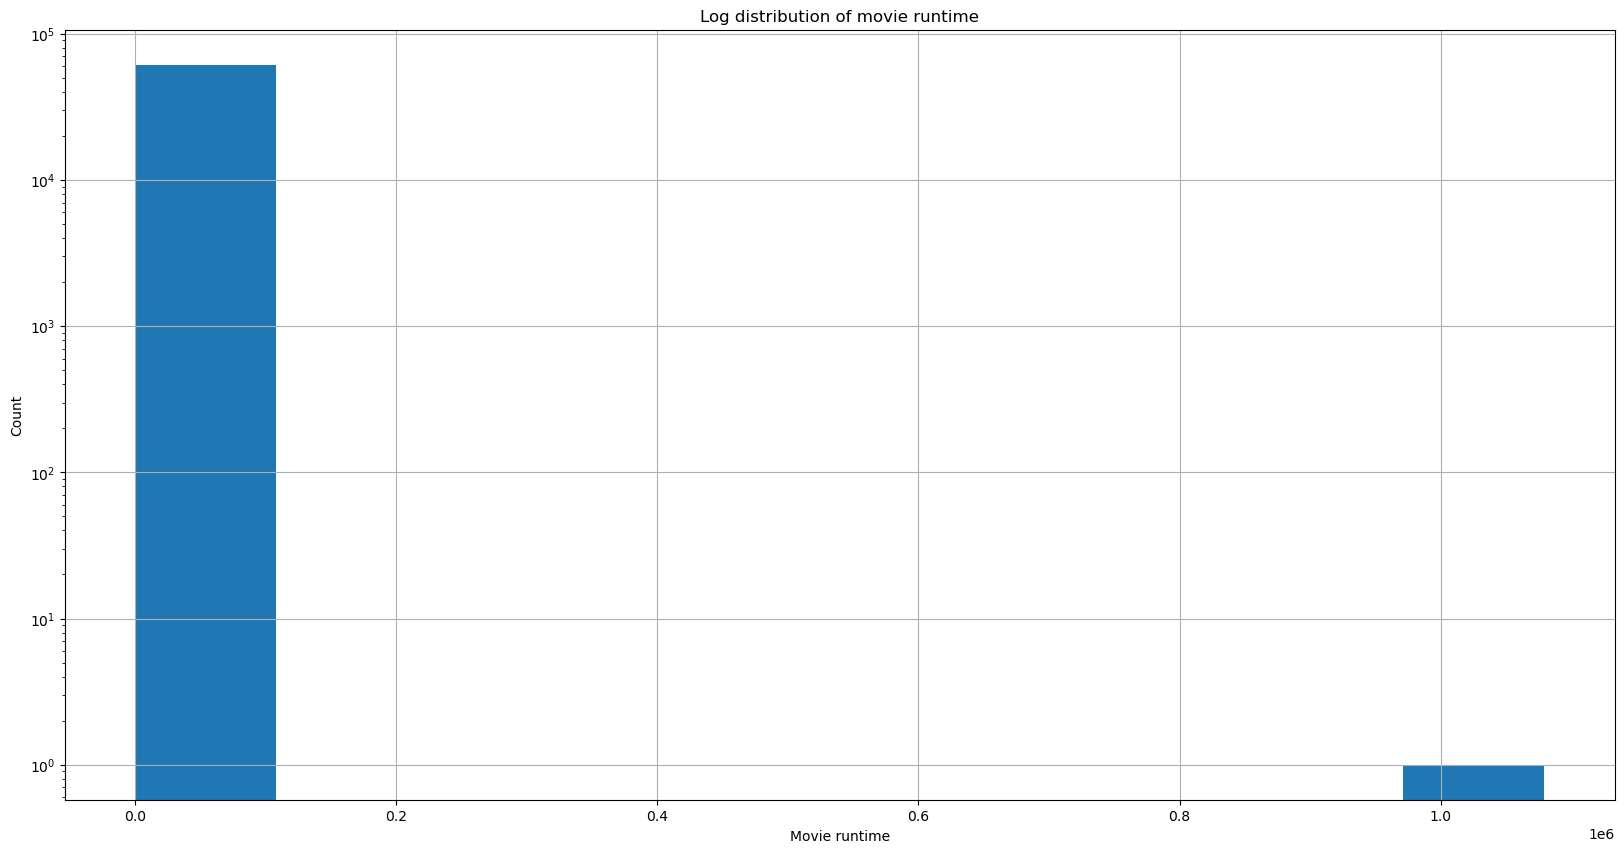

In [70]:
#Distribution of movie runtime
plt.figure(figsize=(20,10))
plt.title('Log distribution of movie runtime')
plt.xlabel('Movie runtime')
plt.ylabel('Count')
plt.yscale('log')
pd_movie.dropna(subset=['Movie runtime'])['Movie runtime'].hist(bins=10)